In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from lob_data_utils import roc_results, gdf_pca
import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_dir = '../gdf_pca/res_lstm2'
filename_pattern = 'res_lstm_unit_{}_len10000_r{}_s{}.csv'
data_regular_dir = '../queue_imbalance/data/prepared/'
stocks = list(roc_results.results_10000.keys())
data_length = 10000
should_save_fig = False

In [3]:
mid_prices = []
df_huge = pd.DataFrame()
for stock in stocks:
    df_reg, df_reg_test = lob.load_prepared_data(
        stock, data_dir=data_regular_dir, cv=False, length=data_length)
    mid_prices.append({
        'stock': int(stock), 'mid_price': df_reg['mid_price'].mean(), 
        'spread': (df_reg['ask_price'] - df_reg['bid_price']).mean(),
        'mid_price_negative': len(df_reg[df_reg['mid_price_indicator'] == 0]),
        'mid_price_positive': len(df_reg[df_reg['mid_price_indicator'] == 1])
    })
    #df_huge = df_huge.append(df_reg)
df_regular = pd.DataFrame(mid_prices)
df_regular.head()

TypeError: load_prepared_data() got an unexpected keyword argument 'cv'

In [4]:
#df_huge.columns

In [5]:
# plt.title('Violin Plots of Queue Imbalance vs Mid Price Indicator')

# sns.violinplot(y=df_huge['queue_imbalance'], x=df_huge['mid_price_indicator'], scale="count", split=True)

# plt.ylabel('Queue Imbalance')
# plt.xlabel('Mid Price Indicator')

# plt.ylabel('Queue Imbalance')
# plt.xlabel('Mid Price Indicator')
# if should_save_fig:
#     plt.savefig('all_stocks_violin_plot_imb_vs_ind.png')

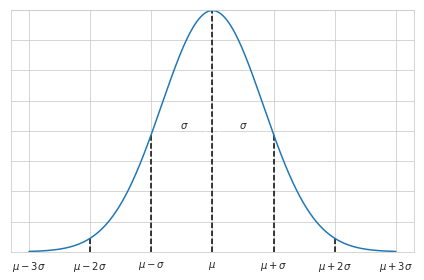

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(-9, 9, 0.001)
# Mean = 0, SD = 2.
plt.plot(x_axis, norm.pdf(x_axis,0,2.5))
plt.vlines(0, 0, 0.18, linestyles='dashed', label='mid price')
plt.vlines(3, 0, 0.078, linestyles='dashed')
plt.vlines(-3, 0, 0.078, linestyles='dashed')
plt.vlines(6, 0, 0.01, linestyles='dashed')
plt.vlines(-6, 0, 0.01, linestyles='dashed')
plt.annotate("", xytext=(-3, 0.078), xy=(0, 0.078), arrowprops=dict(arrowstyle="<->"), label='$\sigma$')
plt.annotate("", xytext=(0, 0.078), xy=(3, 0.078), arrowprops=dict(arrowstyle="<->"), label='$\sigma$')
plt.annotate('$\sigma$', xytext=(-1.6, 0.082), xy=(0, 0.082))
plt.annotate('$\sigma$', xytext=(1.3, 0.082), xy=(3, 0.082))
plt.ylim(0, 0.16)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False, 
    labelleft=False) 
my_xticks = ['$\mu - 3\sigma$', '$\mu - 2\sigma$', '$\mu - \sigma$', 
             '$\mu$', '$\mu + \sigma$', '$\mu + 2\sigma$', '$\mu + 3\sigma$']
a = plt.xticks([-9, -6, -3, 0, 3, 6, 9], my_xticks)
plt.tight_layout()
if should_save_fig:
    plt.savefig('gaussian.png')

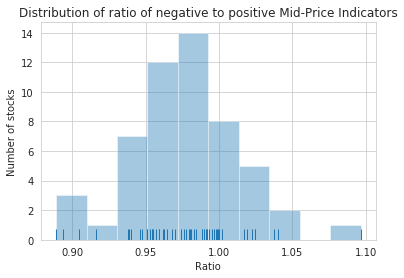

In [7]:
sns.distplot(df_regular['mid_price_negative'] / df_regular['mid_price_positive'], kde=False, rug=True)
plt.xlabel('Ratio')
plt.ylabel('Number of stocks')
plt.title('Distribution of ratio of negative to positive Mid-Price Indicators')
plt.savefig('ratio_mid_price_indicator.png')

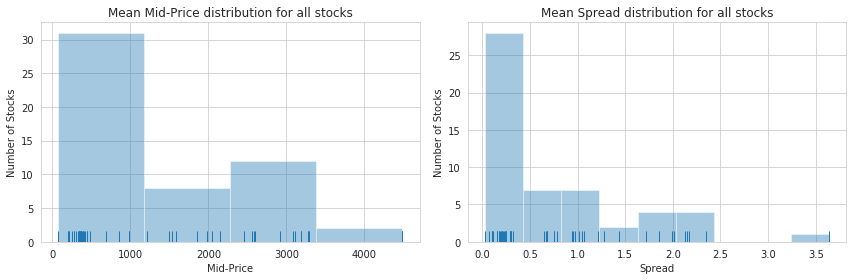

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.distplot(df_regular['mid_price'], kde=False, ax=ax1, rug=True)
ax1.set_xlabel('Mid-Price')
ax1.set_ylabel('Number of Stocks')
ax1.set_title('Mean Mid-Price distribution for all stocks')

sns.distplot(df_regular['spread'], kde=False, ax=ax2, rug=True)
ax2.set_xlabel('Spread')
ax2.set_ylabel('Number of Stocks')

ax2.set_title('Mean Spread distribution for all stocks')
plt.tight_layout()
plt.savefig('mid_price_distribution.png')


In [9]:
df_regular.columns

Index(['mid_price', 'mid_price_negative', 'mid_price_positive', 'spread',
       'stock'],
      dtype='object')

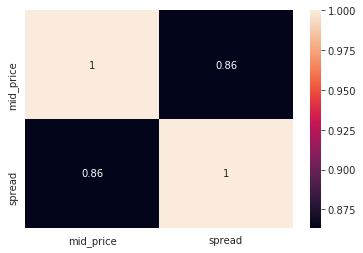

In [10]:
sns.heatmap(df_regular[['mid_price', 'spread']].corr(), annot=True)

Text(0.5,1,'Spread distribution for all stocks')

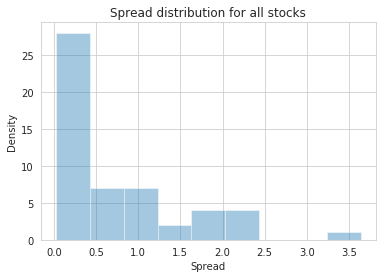

In [11]:
sns.distplot(df_regular['spread'], kde=False)
plt.xlabel('Spread')
plt.ylabel('Density')
plt.title('Spread distribution for all stocks')

In [12]:
df_regular[['mid_price', 'spread']].describe()

,mid_price,spread
count,53.000000,53.000000
mean,1338.327160,0.763437
std,1261.646819,0.785512
min,75.131704,0.026420
25%,352.897625,0.204388
50%,488.642700,0.302538
75%,2462.093375,1.048312
max,4486.275750,3.637750


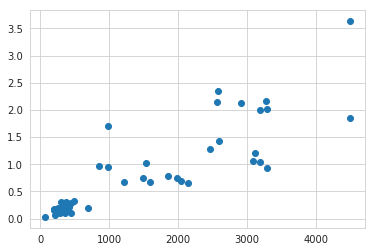

In [13]:
plt.scatter(df_regular['mid_price'], df_regular['spread'])

In [14]:
df_res = pd.DataFrame()
for f in os.listdir(data_dir):
    parts_of_filename = f.split('_')
    stock = parts_of_filename[5]
    r = parts_of_filename[7][1:]
    s = parts_of_filename[8][1:].split('.csv')[0]
    df_stock = pd.read_csv(os.path.join(data_dir, f))
    df_stock['stock'] = [int(stock)] * len(df_stock)
    df_stock['r'] = [float(r)] * len(df_stock)
    df_stock['s'] = [float(s)] * len(df_stock)
    df_res = df_res.append(df_stock)
df_res = df_res[df_res['hidden_layer'] == 1] # tODO:


In [15]:
df_res.columns

Index(['Unnamed: 0', 'f1', 'features', 'hidden_layer', 'kappa', 'kernel',
       'matthews', 'pca_components', 'precision', 'recall', 'roc_auc', 'stock',
       'test_f1', 'test_kappa', 'test_matthews', 'test_precision',
       'test_recall', 'test_roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc',
       'train_val_f1', 'train_val_kappa', 'train_val_matthews',
       'train_val_precision', 'train_val_recall', 'train_val_roc_auc', 'unit',
       'r', 's'],
      dtype='object')

In [16]:
df_res = pd.merge(df_res, df_regular, on='stock')
df_res.columns

Index(['Unnamed: 0', 'f1', 'features', 'hidden_layer', 'kappa', 'kernel',
       'matthews', 'pca_components', 'precision', 'recall', 'roc_auc', 'stock',
       'test_f1', 'test_kappa', 'test_matthews', 'test_precision',
       'test_recall', 'test_roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc',
       'train_val_f1', 'train_val_kappa', 'train_val_matthews',
       'train_val_precision', 'train_val_recall', 'train_val_roc_auc', 'unit',
       'r', 's', 'mid_price', 'mid_price_negative', 'mid_price_positive',
       'spread'],
      dtype='object')

In [17]:
columns = ['stock', 'r', 's', 'features', 'matthews', 'roc_auc', 
           'test_matthews', 'test_roc_auc', 'train_matthews', 'train_roc_auc', 'mid_price', 'spread', 'unit']
df_res[columns].sort_values(by='matthews', ascending=False).groupby(['stock', 'unit']).head(1)

,stock,r,s,features,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,mid_price,spread,unit
127,11946,0.10,1.0,pca_n_gdf_que_prev,0.207073,0.599911,0.198092,0.599020,0.181236,0.590639,195.266563,0.172400,20
129,11946,0.10,0.1,pca_n_gdf_que_prev,0.206595,0.601235,0.186324,0.593169,0.186919,0.593478,195.266563,0.172400,3
122,11946,0.01,0.1,pca_n_gdf_que_prev,0.206153,0.601342,0.200328,0.599975,0.180847,0.590411,195.266563,0.172400,4
120,11946,0.01,0.1,pca_n_gdf_que_prev,0.204923,0.600020,0.198155,0.599061,0.184371,0.592210,195.266563,0.172400,1
126,11946,0.10,1.0,pca_n_gdf_que_prev,0.203625,0.597941,0.200629,0.599847,0.187823,0.593736,195.266563,0.172400,6
121,11946,0.01,0.1,pca_n_gdf_que_prev,0.202475,0.599459,0.198029,0.598979,0.182036,0.591040,195.266563,0.172400,2
118,11946,1.00,0.1,pca_n_gdf_que_prev,0.200292,0.599329,0.194324,0.596556,0.192141,0.596012,195.266563,0.172400,12
776,7858,0.10,1.0,pca_n_gdf_que_prev,0.175437,0.586478,0.151059,0.574064,0.172205,0.586088,4486.275750,3.637750,1
777,7858,0.10,1.0,pca_n_gdf_que_prev,0.172967,0.584971,0.154995,0.575764,0.168620,0.584211,4486.275750,3.637750,5
778,7858,0.10,1.0,pca_n_gdf_que_prev,0.169667,0.583373,0.147598,0.571754,0.168551,0.584146,4486.275750,3.637750,10


In [18]:
df_res[columns].sort_values(by='matthews', ascending=False).groupby(['stock']).head(1)['unit'].value_counts()

1     21
20     8
2      8
8      6
4      6
12     1
10     1
6      1
3      1
Name: unit, dtype: int64

In [19]:
df_res[columns][df_res['s'] == 0.1].sort_values(by='matthews', ascending=False).groupby('stock').head(1)

,stock,r,s,features,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,mid_price,spread,unit
129,11946,0.10,0.1,pca_n_gdf_que_prev,0.206595,0.601235,0.186324,0.593169,0.186919,0.593478,195.266563,0.172400,3
872,2813,0.01,0.1,pca_n_gdf_que_prev,0.164638,0.581995,0.098458,0.549045,0.143301,0.571394,383.283281,0.204388,1
789,7858,1.00,0.1,pca_n_gdf_que_prev,0.164057,0.581034,0.175592,0.586093,0.156015,0.577883,4486.275750,3.637750,4
700,1956,0.01,0.1,pca_n_gdf_que_prev,0.161535,0.575100,0.129132,0.563586,0.149486,0.573914,282.365775,0.156275,1
591,3035,0.01,0.1,pca_n_gdf_que_prev,0.160576,0.579776,0.107440,0.553455,0.172000,0.585822,251.878844,0.196388,20
60,4799,1.00,0.1,pca_n_gdf_que_prev,0.160064,0.579634,0.142838,0.571482,0.140505,0.570216,979.559531,1.713688,1
105,12417,0.01,0.1,pca_n_gdf_que_prev,0.159238,0.577538,0.151847,0.575741,0.153713,0.576852,306.583788,0.300750,2
370,3879,0.10,0.1,pca_n_gdf_que_prev,0.158660,0.579072,0.108202,0.554023,0.171360,0.585588,2462.093375,1.281750,8
664,9086,1.00,0.1,pca_n_gdf_que_prev,0.158335,0.578833,0.125948,0.562828,0.132741,0.566306,217.865897,0.068819,1
154,3022,0.01,0.1,pca_n_gdf_que_prev,0.156609,0.575583,0.152337,0.575921,0.126319,0.562395,394.221775,0.208625,4


In [20]:
df_best = df_res[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_best

,stock,r,s,features,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,mid_price,spread,unit
127,11946,0.10,1.0,pca_n_gdf_que_prev,0.207073,0.599911,0.198092,0.599020,0.181236,0.590639,195.266563,0.172400,20
776,7858,0.10,1.0,pca_n_gdf_que_prev,0.175437,0.586478,0.151059,0.574064,0.172205,0.586088,4486.275750,3.637750,1
872,2813,0.01,0.1,pca_n_gdf_que_prev,0.164638,0.581995,0.098458,0.549045,0.143301,0.571394,383.283281,0.204388,1
52,4799,0.10,1.0,pca_n_gdf_que_prev,0.163650,0.581619,0.154077,0.577071,0.139960,0.569951,979.559531,1.713688,1
596,3035,0.10,1.0,pca_n_gdf_que_prev,0.162297,0.580631,0.102491,0.551019,0.173258,0.586475,251.878844,0.196388,1
700,1956,0.01,0.1,pca_n_gdf_que_prev,0.161535,0.575100,0.129132,0.563586,0.149486,0.573914,282.365775,0.156275,1
105,12417,0.01,0.1,pca_n_gdf_que_prev,0.159238,0.577538,0.151847,0.575741,0.153713,0.576852,306.583788,0.300750,2
324,10508,0.10,1.0,pca_n_gdf_que_prev,0.158871,0.579183,0.143232,0.571513,0.147267,0.573561,355.728538,0.245200,1
370,3879,0.10,0.1,pca_n_gdf_que_prev,0.158660,0.579072,0.108202,0.554023,0.171360,0.585588,2462.093375,1.281750,8
664,9086,1.00,0.1,pca_n_gdf_que_prev,0.158335,0.578833,0.125948,0.562828,0.132741,0.566306,217.865897,0.068819,1


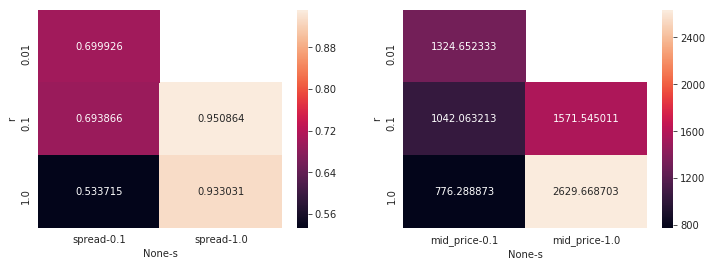

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
df_best1 = df_best[['r', 's', 'spread']]
sns.heatmap(df_best1.groupby(['r', 's']).mean().unstack(), annot=True, fmt='f', ax=ax1)
df_best1 = df_best[['r', 's', 'mid_price']]
sns.heatmap(df_best1.groupby(['r', 's']).mean().unstack(), annot=True, fmt='f', ax=ax2)

In [22]:
# mean 1338.327160 0.763437

df_smallest = df_res[df_res['mid_price'] < 1338.32]
df_smallest = df_smallest[df_smallest['spread'] < 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_smallest['matthews'].mean()

0.1320200947196679

In [23]:
df_smallest = df_res[df_res['mid_price'] > 1338.32]
df_smallest = df_smallest[df_smallest['spread'] < 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_smallest['test_matthews'].mean()

0.10226771070398422

In [24]:
df_smallest = df_res[df_res['mid_price'] < 1338.32]
df_smallest = df_smallest[df_smallest['spread'] > 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01]
df_smallest = df_smallest[df_smallest['s'] == 1.0]
df_smallest[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_smallest['test_matthews'].mean()

nan

In [25]:
df_smallest = df_res[df_res['mid_price'] < 1338.32]
df_smallest = df_smallest[df_smallest['spread'] < 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 1.0]
df_smallest[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_smallest['test_matthews'].mean()

0.1110806562301521

In [26]:
df_best['r'].value_counts(), df_best['s'].value_counts()

(0.10    23
 0.01    20
 1.00    10
 Name: r, dtype: int64, 0.1    34
 1.0    19
 Name: s, dtype: int64)

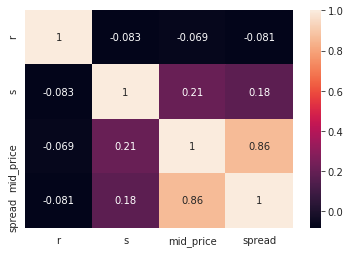

In [27]:
sns.heatmap(df_best[['r', 's', 'mid_price', 'spread']].corr(), annot=True)

,test_matthews,matthews,test_roc_auc,roc_auc
count,53.000000,53.000000,53.000000,53.000000
mean,0.115315,0.135408,0.556956,0.566592
std,0.029794,0.023923,0.015023,0.011674
min,0.046831,0.074178,0.523230,0.537094
25%,0.096928,0.123430,0.547888,0.560330
50%,0.110176,0.134900,0.554023,0.566909
75%,0.134669,0.150500,0.567261,0.574457
max,0.198092,0.207073,0.599020,0.599911


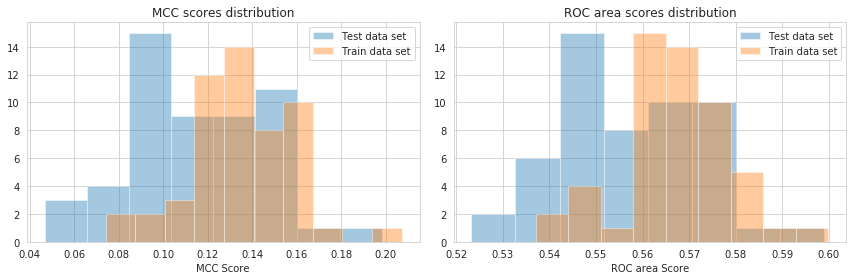

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.distplot(df_best['test_matthews'], kde=False, label='Test data set', ax=ax1)
sns.distplot(df_best['matthews'], kde=False, label='Train data set', ax=ax1)

ax1.legend()
ax1.set_xlabel('MCC Score')
ax1.set_title('MCC scores distribution')

sns.distplot(df_best['test_roc_auc'], kde=False, label='Test data set', ax=ax2)
sns.distplot(df_best['roc_auc'], kde=False, label='Train data set', ax=ax2)

ax2.legend()
ax2.set_xlabel('ROC area Score')
ax2.set_title('ROC area scores distribution')
plt.tight_layout()
plt.savefig('results_mlp_pca_score_dist.png')

df_best[['test_matthews', 'matthews', 'test_roc_auc', 'roc_auc']].describe()

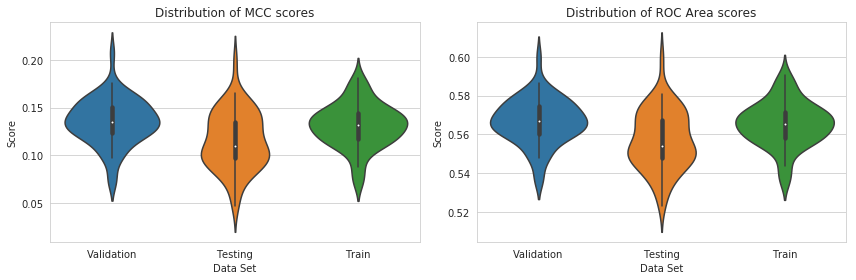

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

df = df_best.copy()
df.rename(columns={'matthews': 'Validation', 'test_matthews': 'Testing', 'train_matthews': 'Train'}, inplace=True)
df = df.melt(['stock', 'r', 's',  'features', 'spread', 'mid_price', 
                   'roc_auc', 'test_roc_auc', 'train_roc_auc', 'unit'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best.copy()
df.rename(columns={'roc_auc': 'Validation', 'test_roc_auc': 'Testing', 'train_roc_auc': 'Train'}, inplace=True)
df = df.melt(['stock', 'r', 's', 'features', 'spread', 'mid_price', 
                   'matthews', 'test_matthews', 'train_matthews', 'unit'])

ax2.set_title('Distribution of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')
plt.tight_layout()
plt.savefig('violin_distribution_scores_mlp.png')

In [30]:
print(df_best[['test_matthews', 'matthews', 'test_roc_auc', 'roc_auc']].describe().to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  test\_matthews &   matthews &  test\_roc\_auc &    roc\_auc \\
\midrule
count &      53.000000 &  53.000000 &     53.000000 &  53.000000 \\
mean  &       0.115315 &   0.135408 &      0.556956 &   0.566592 \\
std   &       0.029794 &   0.023923 &      0.015023 &   0.011674 \\
min   &       0.046831 &   0.074178 &      0.523230 &   0.537094 \\
25\%   &       0.096928 &   0.123430 &      0.547888 &   0.560330 \\
50\%   &       0.110176 &   0.134900 &      0.554023 &   0.566909 \\
75\%   &       0.134669 &   0.150500 &      0.567261 &   0.574457 \\
max   &       0.198092 &   0.207073 &      0.599020 &   0.599911 \\
\bottomrule
\end{tabular}



In [31]:
df_best = df_res[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)

df_log = pd.read_csv('../gdf_pca/res_log_que.csv')
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['', '_log'])

In [33]:
df = df_best.copy()
columns = ['stock', 'r', 's', 'alpha', 'features', 'matthews_mlp', 'roc_auc_mlp',
       'test_matthews_mlp', 'test_roc_auc_mlp', 'train_matthews_mlp',
       'train_roc_auc_mlp', 'mid_price', 'spread', 'Unnamed: 0', 'f1', 'kappa',
       'matthews_log', 'precision', 'recall', 'roc_auc_log', 'test_f1_score',
       'test_kappa', 'test_matthews_log', 'test_precision', 'test_recall',
       'test_roc_auc_log', 'train_f1', 'train_kappa', 'train_matthews_log',
       'train_precision', 'train_recall', 'train_roc_auc_log']

df['test_matthews_diff'] = df['test_matthews'] - df['test_matthews_log']
df['train_matthews_diff'] = df['train_matthews'] - df['train_matthews_log']
df['validation_matthews_diff'] = df['matthews'] - df['matthews_log']
df['test_roc_auc_diff'] = df['test_roc_auc'] - df['test_roc_auc_log']
df['train_roc_auc_diff'] = df['train_roc_auc'] - df['train_roc_auc_log']
df['validation_roc_auc_diff'] = df['roc_auc'] - df['roc_auc_log']

print(df[['test_matthews_diff', 'train_matthews_diff', 'validation_matthews_diff',
   'test_roc_auc_diff', 'train_roc_auc_diff', 'validation_roc_auc_diff']].describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  test\_matthews\_diff &  train\_matthews\_diff &  validation\_matthews\_diff &  test\_roc\_auc\_diff &  train\_roc\_auc\_diff &  validation\_roc\_auc\_diff \\
\midrule
count &           53.000000 &            53.000000 &                 53.000000 &          53.000000 &           53.000000 &                53.000000 \\
mean  &           -0.002019 &             0.003689 &                  0.005698 &          -0.001138 &            0.001815 &                 0.002878 \\
std   &            0.012261 &             0.006630 &                  0.011147 &           0.005982 &            0.003290 &                 0.005650 \\
min   &           -0.034585 &            -0.007047 &                 -0.017733 &          -0.017674 &           -0.003544 &                -0.008959 \\
25\%   &           -0.008832 &             0.000547 &                 -0.000673 &          -0.004462 &           -0.000065 &                -0.000139 \\
50\%   &           -0.002574 &  

In [ ]:
df[['test_matthews_diff', 'train_matthews_diff', 'validation_matthews_diff',
   'test_roc_auc_diff', 'train_roc_auc_diff', 'validation_roc_auc_diff']].describe()

In [34]:
print(df[df['test_matthews_diff'] > 0]['stock'].count(), df[df['test_roc_auc_diff'] > 0]['stock'].count())
print(df[df['train_matthews_diff'] > 0]['stock'].count(), df[df['train_roc_auc_diff'] > 0]['stock'].count())
print(df[df['validation_matthews_diff'] > 0]['stock'].count(), df[df['validation_roc_auc_diff'] > 0]['stock'].count())

20 21
40 39
38 39


In [35]:
df[df['test_matthews_diff'] > 0]['stock'].count(), df[df['test_roc_auc_diff'] > 0]['stock'].count()

(20, 21)

In [36]:
df.columns

Index(['stock', 'r', 's', 'features', 'matthews', 'roc_auc', 'test_matthews',
       'test_roc_auc', 'train_matthews', 'train_roc_auc', 'mid_price',
       'spread', 'unit', 'Unnamed: 0', 'f1', 'kappa', 'kernel', 'matthews_log',
       'precision', 'recall', 'roc_auc_log', 'test_f1', 'test_kappa',
       'test_matthews_log', 'test_precision', 'test_recall',
       'test_roc_auc_log', 'train_f1', 'train_kappa', 'train_matthews_log',
       'train_precision', 'train_recall', 'train_roc_auc_log', 'train_val_f1',
       'train_val_kappa', 'train_val_matthews', 'train_val_precision',
       'train_val_recall', 'train_val_roc_auc', 'test_matthews_diff',
       'train_matthews_diff', 'validation_matthews_diff', 'test_roc_auc_diff',
       'train_roc_auc_diff', 'validation_roc_auc_diff'],
      dtype='object')

In [44]:
stocks_bad = df[df['test_matthews_diff'] < 0]['stock'].values
d = d.sort_values(by='matthews', ascending=False).groupby('stock').head(1)
print(d.columns)
c = ['stock', 'r', 's', 'matthews', 'matthews_log', 'hidden_layer', 'unit', 'pca_components',
           'test_matthews', 'test_matthews_log', 'train_matthews', 'mid_price', 'spread']

df_bad = d[d['stock'].isin(stocks_bad)]
df_bad = pd.merge(df_bad, df_log, on='stock', suffixes=['','_log'])
df_bad[df_bad['test_matthews'] < df_bad['test_matthews_log']][c]

Index(['Unnamed: 0', 'f1', 'features', 'hidden_layer', 'kappa', 'kernel',
       'matthews', 'pca_components', 'precision', 'recall', 'roc_auc', 'stock',
       'test_f1', 'test_kappa', 'test_matthews', 'test_precision',
       'test_recall', 'test_roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc',
       'train_val_f1', 'train_val_kappa', 'train_val_matthews',
       'train_val_precision', 'train_val_recall', 'train_val_roc_auc', 'unit',
       'r', 's', 'mid_price', 'mid_price_negative', 'mid_price_positive',
       'spread'],
      dtype='object')


,stock,r,s,matthews,matthews_log,hidden_layer,unit,pca_components,test_matthews,test_matthews_log,train_matthews,mid_price,spread
0,11946,0.10,1.0,0.207073,0.201987,1,20,3,0.198092,0.206865,0.181236,195.266563,0.172400
1,7858,0.10,1.0,0.175437,0.137606,1,1,5,0.151059,0.172935,0.172205,4486.275750,3.637750
2,2813,0.01,0.1,0.164638,0.160789,1,1,2,0.098458,0.106079,0.143301,383.283281,0.204388
3,1956,0.01,0.1,0.161535,0.159953,1,1,2,0.129132,0.134599,0.149486,282.365775,0.156275
4,12417,0.01,0.1,0.159238,0.156049,1,2,2,0.151847,0.157526,0.153713,306.583788,0.300750
5,10508,0.10,1.0,0.158871,0.143805,1,1,4,0.143232,0.155669,0.147267,355.728538,0.245200
6,3879,0.10,0.1,0.158660,0.162945,1,8,4,0.108202,0.113455,0.171360,2462.093375,1.281750
7,9086,1.00,0.1,0.158335,0.148086,1,1,4,0.125948,0.132822,0.132741,217.865897,0.068819
8,3022,0.01,0.1,0.156609,0.149472,1,4,2,0.152337,0.154686,0.126319,394.221775,0.208625
9,1472,0.10,1.0,0.153499,0.142472,1,8,4,0.110176,0.122255,0.141687,449.038569,0.289588


## Results by r s using the alg

In [ ]:
df_best_alg = pd.DataFrame()
df_smallest = df_res[df_res['mid_price'] <= 1338.32]
df_smallest = df_smallest[df_smallest['spread'] <= 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest['cat'] = [0 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))
    
    
df_smallest = df_res[df_res['mid_price'] > 1338.32]
df_smallest = df_smallest[df_smallest['spread'] <= 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest['cat'] = [1 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))

df_smallest = df_res[df_res['mid_price'] <= 1338.32]
df_smallest = df_smallest[df_smallest['spread'] > 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01] # 0.01 #TODO: it is currently the same...
df_smallest = df_smallest[df_smallest['s'] == 1.0]
df_smallest['cat'] = [2 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))

df_smallest = df_res[df_res['mid_price'] > 1338.32]
df_smallest = df_smallest[df_smallest['spread'] > 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 1.0]
df_smallest['cat'] = [3 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))

c = ['stock', 'r', 's', 'cat', 'matthews', 'matthews_log', 
           'test_matthews', 'test_matthews_log', 'train_matthews', 'mid_price', 'spread']

df_best_alg = pd.merge(df_best_alg, df_log, on='stock', suffixes=['', '_log'])
print(len(df_best_alg[df_best_alg['test_matthews'] > df_best_alg['test_matthews_log']]))
df_best_alg[c].head()

In [ ]:
df_best_alg = pd.DataFrame()
df_smallest = df_res[df_res['mid_price'] <= 1338.32]
df_smallest = df_smallest[df_smallest['spread'] <= 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest['cat'] = [0 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))
    
    
df_smallest = df_res[df_res['mid_price'] > 1338.32]
df_smallest = df_smallest[df_smallest['spread'] <= 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest['cat'] = [1 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))

df_smallest = df_res[df_res['mid_price'] <= 1338.32]
df_smallest = df_smallest[df_smallest['spread'] > 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.01] # 0.01 #TODO: it is currently the same...
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest['cat'] = [2 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))

df_smallest = df_res[df_res['mid_price'] > 1338.32]
df_smallest = df_smallest[df_smallest['spread'] > 0.7634]
df_smallest = df_smallest[df_smallest['r'] == 0.1]
df_smallest = df_smallest[df_smallest['s'] == 0.1]
df_smallest['cat'] = [3 for i in range(len(df_smallest))]
df_best_alg = df_best_alg.append(df_smallest.sort_values(
    by='matthews', ascending=False).groupby('stock').head(1))

c = ['stock', 'r', 's', 'cat', 'matthews', 'matthews_log', 
           'test_matthews', 'test_matthews_log', 'train_matthews', 'mid_price', 'spread']

df_best_alg = pd.merge(df_best_alg, df_log, on='stock', suffixes=['', '_log'])
print(len(df_best_alg[df_best_alg['test_matthews'] > df_best_alg['test_matthews_log']]))
df_best_alg[c].head()